# **Applying DRL for FIR Filter Implementation - Stage 1 - Section 3.3** 

## Scope - *Training a Custom DDPG Agent With More Audio Data*
References:- the book, *Deep Reinforcement Learning for Wireless Communications and Networking*

In [1]:
import os, sys, time, copy
import json
import wave
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy.fft import fft, rfft, fftshift, fftfreq
from scipy.signal import convolve, freqz

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, HER, PPO, SAC, TD3
from stable_baselines3.common.base_class import BaseAlgorithm, VecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

sys.path.append('../')
from helper import to_min_size_int_array, Spectrum, LPF, apply_filter, mean_L1_dist, SNR, create_target_and_jammed_signals, trim_audio
from DDPG import DDPGAgent

2023-11-28 08:39:31.395415: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 08:39:31.686899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 08:39:31.686927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 08:39:31.688329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 08:39:31.818881: I tensorflow/core/platform/cpu_feature_g

### **The Custom Environment**

In [90]:
class ReceiverEnv(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a receiver environment. 
    :param N: FIR filter length, must be an odd integer 
    :param S: signal partition size which will be used to calculate the receiver buffer size
    :param cut_off_freq: the frequency to truncate the audio spectrum to generate the target signal; equivalent to the ideal cut-off frequency of the learned filter
    :param interference_center_freq: the frequency to shift the target spectrum to generate the non-overlapping interference
    :param audio_json: path of a json file containing the names of the audio wav files the environment can access\
        put the audio file names without the .wav extension in a json array inside the file
    """

    # define constants 
    MIN_BUFFER_SIZE = 10 # RAISE THIS LATER!!!
    EPISODE_LENGTH  = np.inf # np.inf
    MAX_TOTAL_NUM_OF_STEPS = np.inf

    def __init__(self, N:int, S:int, cut_off_freq:int, interference_center_freq:int, audio_json:str = 'audio_files/audio_files.json'):

        super(ReceiverEnv, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # filter length 
        if N%2 != 1:
            raise Exception(f"FIR filter length 'N' must be an odd integer: given {N}")
        self.N = N

        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S
        # buffer size 
        self.buffer_size = S + N - 1

        # other parameters
        self.cut_off_freq = cut_off_freq
        self.interference_center_freq = interference_center_freq
        self.audio_json = audio_json

        # ----------------------------- Action Space -----------------------------
        # action - choosing the filter coefficients [from index 0 to (N-1)/2]; 
        # note that the action is NOT TUNING/ADJUSTING/CHANGING the coefficeints of an existing filter that the agent is not aware of. 
        action_shape = (int((N+1)/2), )
        self.action_space = spaces.Box(low=-1, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32

        # ----------------------------- State Space ------------------------------
        state_shape = (self.buffer_size, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)

        # ------------------------- other class attributes ------------------------
        self.global_counter = 0  # a counter to keep track of the number of elapsed time steps of the environment
        self.counter = 0         # a counter to keep track of the number of elapsed time steps in the current episode
        self.episode_counter = 0 # a counter to keep track of the number of total episodes

    def reset(self, seed=None, options=None):

        super().reset(seed=seed, options=None) # options must be forced to None

        # reset the counters
        if options is dict and 'reset_all' in options and options['reset_all'] == True:
            self.global_counter  = 0
            self.episode_counter = 0
        self.counter = 0
        self.episode_counter += 1

        print('\n' + "-" * 50 + f"episode no: {self.episode_counter}" + "-" * 50)

        # for each episode, choose the audio signal specified by `audio_num` in the options
        with open(self.audio_json) as audio_json_file:
            train_audio_names = json.load(audio_json_file)["train"]
        audio_num = 0 # default audio track - 'vignesh.wav'
        if options is dict and 'audio_num' in options:
            audio_num = options['audio_num']
        
        # i = np.random.randint(low=1, high=self.audio_num) # len(train_audio_names)
        # create the target and jammed signals
        target_signal, jammed_signal = create_target_and_jammed_signals(train_audio_names[audio_num], self.cut_off_freq, self.interference_center_freq, self.S)
        self.target_signal = target_signal
        self.jammed_signal = jammed_signal

        # return the initial state 
        self.state = jammed_signal[:self.buffer_size]

        info = {}

        # return the initial state and info
        return self.state, info

    def step(self, action):

        # increment the counters
        self.global_counter += 1
        self.counter += 1

        # create the filter 
        filter = np.concatenate((action[-1:0:-1], action))

        # get signal partition from the buffer
        partition = self.state
        # print(f"step: {self.counter}, state: {partition}")

        # generating the next state
        terminated = False
        if (self.S * self.counter) + self.buffer_size >= len(self.jammed_signal):
            terminated = True
        else:
            self.state = self.jammed_signal[(self.S * self.counter) : (self.S * self.counter) + self.buffer_size]

        # apply the filter to the current state (not on the next state)
        filtered = apply_filter(filter, partition)[(self.N-1)//2 : (self.N-1)//2 + self.S]
        target   = self.target_signal[(self.N-1)//2 + self.S * (self.counter - 1) : (self.N-1)//2 + self.S * (self.counter - 1) + self.S]
        # print(f"filtered: {filtered}")
        # print(f"target:   {target}")

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            raise Exception(f"reward value is not a number...\ntarget: {target}\nfiltered: {filtered}\nfilter: {filter}")
        
        # if self.counter % 50 == 1:
        print(f"step: {self.counter}, SNR: {reward}, filter: {filter}")
        
        # truncating the episode
        truncated = False
        if self.episode_counter == self.EPISODE_LENGTH or self.global_counter == self.MAX_TOTAL_NUM_OF_STEPS:
            truncated = True
        
        info = {}

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass


In [ ]:
# checking the environment
env = ReceiverEnv(N=5, S=100, cut_off_freq=5_000, interference_center_freq=15_000, audio_num=2)
check_env(env)

### **DDPG Agent**

In [40]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.losses import MSE


# =============================== REPLAY BUFFER ===============================
class ReplayBuffer:
    def __init__(self, max_size, state_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory     = np.zeros((self.mem_size, *state_shape))
        self.action_memory    = np.zeros((self.mem_size, n_actions))
        self.reward_memory    = np.zeros(self.mem_size)
        self.new_state_memory = np.zeros((self.mem_size, *state_shape))
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.bool_) # using np.bool is really useful when pytorch is used.

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size # implement a queue

        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = new_state
        self.terminal_memory[index]  = done # problematic !!!

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False) # replace = False -> in a single batch, no element gets sampled more than once. 

        states     = self.state_memory[batch]
        actions    = self.action_memory[batch]
        rewards    = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones      = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones



# =============================== CRITIC NETWORK ===============================
class CriticNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(CriticNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 
        # extensions for saving keras models: legacy '.h5' -> TF 1.X, '.tf' -> TF 2.X

        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # # define network layers 
        # self.fc1 = Dense(self.fc1_dims, activation='relu')
        # self.fc2 = Dense(self.fc2_dims, activation='relu')
        # self.q   = Dense(1, activation=None)

        # # define network layers 
        # self.hidden1  = Dense(self.fc1_dims, activation='relu', name="critic_hidden1")
        # self.hidden2  = Dense(self.fc2_dims, activation='relu', name="critic_hidden2")
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # self.hidden2_ = Dense(self.fc2_dims, activation='relu', name="critic_hidden2_")
        # self.q        = Dense(1, activation=None, name="q_value") # change the activation appropriately

        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)

        # define network layers
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims,
            activation='relu',
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name="critic_hidden1"
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2"
        )
        self.action_normalizer  = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2_ = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2_"
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.q = Dense(
            units=1,
            activation=None, # None
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name="q_value"
        )

    def call(self, state, action):
        # # temp1 = self.fc1(tf.concat([state, action], axis=1)) # axis 0 -> batch dimension
        # temp1 = self.fc1(action)
        # # ######################## PROBLEM ########################
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # temp2 = self.fc2(temp1)
        # q_value = self.q(temp2)

        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_action  = self.action_normalizer(action) # may not be required since action is already bounded between [-1, +1], but they may be too small compared to normalized_hidden1 activations
        # hidden2_           = self.hidden2_(normalized_action)
        hidden2_           = self.hidden2_(action)
        normalized_hidden2 = self.hidden2_normalizer(tf.concat([hidden2, hidden2_], axis=1)) ######
        q_value            = self.q(normalized_hidden2)
        # q_value = self.q(tf.concat([hidden2, hidden2_], axis=1))

        return q_value

# ================================ ACTOR NETWORK ===============================
class ActorNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            n_actions, # action shape (dimenisonality of action space)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(ActorNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 

        self.n_actions = n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # weight and bias initialziers
        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)
        

        # define network layers including layer noramlizations
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims, 
            activation='relu', 
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name='actor_hidden1'
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name='actor_hidden2'
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.mu = Dense(
            units=n_actions,
            activation='tanh', # limit the action in the range [-1, 1] -> 'tanh'
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name='action'
        )

        # self.hidden1 = Dense(self.fc1_dims,  activation='relu', name='actor_hidden1')
        # self.hidden2 = Dense(self.fc2_dims,  activation='relu', name='actor_hidden2')
        # self.mu  = Dense(self.n_actions, activation='tanh') # action is bounded by +/- 1

    def call(self, state):
        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_hidden2 = self.hidden2_normalizer(hidden2)
        # action             = self.mu(normalized_hidden2)
        action             = self.mu(hidden2)

        return action



# ================================== DDPG AGENT =================================
class DDPGAgent:
    def __init__(
            self,
            input_dims, # state shape
            n_actions,  # dimensionality of actions
            # env,        # gymnasium env
            alpha,      # learning rate of actor
            beta,       # learning rate of critic
            gamma,      # discounting factor
            tau,        # soft target update factor
            critic_fc1,
            critic_fc2,
            actor_fc1,
            actor_fc2,
            batch_size,
            buffer_size,
            noise
    ):
        # set the class attributes
        self.tau = tau
        self.n_actions = n_actions
        self.noise = noise
        self.batch_size = batch_size
        self.gamma = gamma

        # instantiate replay buffer
        self.memory = ReplayBuffer(buffer_size, state_shape=input_dims, n_actions=n_actions)

        # instantiate the networks
        self.actor  = ActorNetwork(name="actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.critic = CriticNetwork(name="critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)
        self.target_actor  = ActorNetwork(name="target_actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.target_critic = CriticNetwork(name="target_critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)

        # compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        # target networks do not require an optimizer or a learning rate since they are learned through soft updates.
        # but, to use the networks in TF2, we have to compile them with an optimizer and a learning rate. 
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        # load identical weights to target networks
        self.update_target_network_parameters(tau=1)

    def update_target_network_parameters(self, tau=None):
        if tau == None:
            tau = self.tau

        target_actor_weights = self.target_actor.weights
        for i, actor_weights in enumerate(self.actor.weights):
            target_actor_weights[i] = tau * actor_weights + (1-tau) * target_actor_weights[i]
        self.target_actor.set_weights(target_actor_weights)

        target_critic_weights = self.target_critic.weights
        for i, critic_weights in enumerate(self.critic.weights):
            target_critic_weights[i] = tau * critic_weights + (1-tau) * target_critic_weights[i]
        self.target_critic.set_weights(target_critic_weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self):
        print("..... saving models .....")
        self.actor.save_weights(self.actor.checkpoint_file)
        self.critic.save_weights(self.critic.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.target_critic.save_weights(self.target_critic.checkpoint_file)

    def load_models(self):
        print("..... loading models .....")
        self.actor.load_weights(self.actor.checkpoint_file)
        self.critic.load_weights(self.critic.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.target_critic.load_weights(self.target_critic.checkpoint_file)

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32) # introducing the batch dimension
        action = self.actor(state) # 'action' would also have a batch dimension 

        if not evaluate:
            # while training the agent, introduce an exploration noise
            # here, the exploration noise is sampled from a normal distribution with zero mean and specified std deviation. 
            action += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=self.noise)
            # when added the noise, the action can go beyond the action space limits; so, clip the actions.
            # action = tf.clip_by_value(action, clip_value_max=1.0, clip_value_min=-1.0)

        return action[0] # get rid of the batch dimension
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states     = tf.convert_to_tensor(state, dtype=tf.float32)
        actions    = tf.convert_to_tensor(action, dtype=tf.float32)
        rewards    = tf.convert_to_tensor(reward, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_state, dtype=tf.float32)

        # update the critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(new_states)
            next_step_critic_values = tf.squeeze(self.target_critic(new_states, target_actions), axis=1)
            critic_values = tf.squeeze(self.critic(states, actions), axis=1)
            targets = rewards + self.gamma * next_step_critic_values * (1-done) # y_i
            critic_loss = MSE(targets, critic_values)
        
        critic_network_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(critic_network_gradients, self.critic.trainable_variables))

        # update the actor
        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            critic_values_ = -self.critic(states, new_policy_actions) # why - ? gradient ascent
            actor_loss = tf.math.reduce_mean(critic_values_)

        actor_network_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradients, self.actor.trainable_variables))

        # soft target updates
        self.update_target_network_parameters()


In [ ]:
env = ReceiverEnv(N=5, S=100, cut_off_freq=5_000, interference_center_freq=15_000, audio_num=5)

model = DDPGAgent(
    input_dims  = env.observation_space.shape,
    n_actions   = env.action_space.shape[0],
    alpha       = 0.0001, # learning rate of actor
    beta        = 0.001,  # learning rate of critic
    gamma       = 0.1,
    tau         = 0.001,
    critic_fc1  = 256,
    critic_fc2  = 128,
    actor_fc1   = 128,
    actor_fc2   = 128,
    batch_size  = 128,
    buffer_size = 1000,
    noise       = 0.01
)
keras.backend.clear_session()

max_num_steps = 128 * 15
reward_history = []
action_history = []
step_count = 0

# reset the environment
state, _ = env.reset(options='reset_all')
done = False
while not done:
    # feed the state to the agent (model) and get an action
    action = model.choose_action(state) # this includes the exploration noise

    # take the action in the environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated | truncated
    step_count += 1

    # store the transition in the replay buffer of the DDPG agent
    model.remember(state, action, reward, next_state, done)

    # train the model
    model.learn()

    # set the `next_state` as `state`
    state = next_state

    # keep track of the `reward`
    reward_history.append(reward)

    action_history.append(action)
    
    if step_count >= max_num_steps:
        done = True


In [91]:
def train(model_, env_, audio_num, max_num_steps):
    """
    Train a model in a given environment with the specified number of time steps
    :param model_: the DRL model 
    :param env_: the environment the model is going to trained in
    :param audio_num: the number/index of the audio track to be used as the training data
    :param max_num_steps: the maximum number of time steps for training

    Returns None
    """

    reward_history = []
    action_history = []
    step_count = 0

    # reset the environment
    state, _ = env_.reset(options={'reset_all': True, 'audio_num':audio_num}) # FOR SINGLE EPISODE
    done = False

    while not done:
        # feed the state to the agent (model) and get an action
        action = model_.choose_action(state) # this includes the exploration noise

        # take the action in the environment
        next_state, reward, terminated, truncated, _ = env_.step(action)
        done = terminated | truncated
        step_count += 1

        # store the transition in the replay buffer of the DDPG agent
        model_.remember(state, action, reward, next_state, done)

        # train the model
        model_.learn()

        # set the `next_state` as `state`
        state = next_state

        # keep track of the `reward` and `action`
        reward_history.append(reward)
        action_history.append(action)
        
        if step_count >= max_num_steps:
            done = True


In [92]:
env = ReceiverEnv(N=5, S=100, cut_off_freq=5_000, interference_center_freq=15_000)

model = DDPGAgent(
    input_dims  = env.observation_space.shape,
    n_actions   = env.action_space.shape[0],
    alpha       = 0.0001, # learning rate of actor
    beta        = 0.001,  # learning rate of critic
    gamma       = 0.1,
    tau         = 0.001,
    critic_fc1  = 256,
    critic_fc2  = 128,
    actor_fc1   = 128,
    actor_fc2   = 128,
    batch_size  = 128,
    buffer_size = 1000,
    noise       = 0.01
)
keras.backend.clear_session()

train(model, env, audio_num=5, max_num_steps=1280)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'vignesh'
sampling rate: 44100 Hz
audio shape: (136477,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -13841.346435316103 (>=-32768) to max: 14399.410754652867 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 0 and upper -1 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -38983.15088455426 (>=-2147483648) to max: 41992.824003714835 (<=2147483647)
step: 1, SNR: 0.10430786872590947, filter: [ 0.00230848 -0.00144176 -0.01137156 -0.00144176  0.00230848]
step: 2, SNR: 0.47051320547248543, filter: [ 0.01081136 -0.00358429  0.01239289 -0.00358429  0.01081136]
st

/home/akila/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


step: 16, SNR: -0.12933560792480714, filter: [-0.00443879 -0.00915221  0.00227367 -0.00915221 -0.00443879]
step: 17, SNR: -0.2991576697048464, filter: [-0.0060945  -0.01398299  0.00346571 -0.01398299 -0.0060945 ]
step: 18, SNR: -0.20189407738355689, filter: [-0.00693664 -0.00483604 -0.00249717 -0.00483604 -0.00693664]
step: 19, SNR: -0.011416903285278262, filter: [ 0.00040164 -0.00635291  0.0097538  -0.00635291  0.00040164]
step: 20, SNR: -0.15113459037597732, filter: [-0.00015059 -0.0107687   0.00401501 -0.0107687  -0.00015059]
step: 21, SNR: -0.44434908765763204, filter: [-0.0061885  -0.01697941 -0.00636106 -0.01697941 -0.0061885 ]
step: 22, SNR: -0.1557350367962086, filter: [-0.00496755 -0.00390547 -0.00087584 -0.00390547 -0.00496755]
step: 23, SNR: 0.2173039726476492, filter: [ 0.01366608  0.00304546 -0.00852201  0.00304546  0.01366608]
step: 24, SNR: 0.15805238941291339, filter: [-0.00114841  0.01697694 -0.01334662  0.01697694 -0.00114841]
step: 25, SNR: -0.14208786722640687, filt

In [6]:
def smoother(array, window_size=10):
    temp = [np.average(array[:window_size])] * window_size
    for i in range(window_size, len(array)):
        temp.append(np.average(array[i-window_size:i]))
    return temp

# array = list(np.arange(20))
# len(smoother(array))

Text(0.5, 1.0, 'coefficient 2')

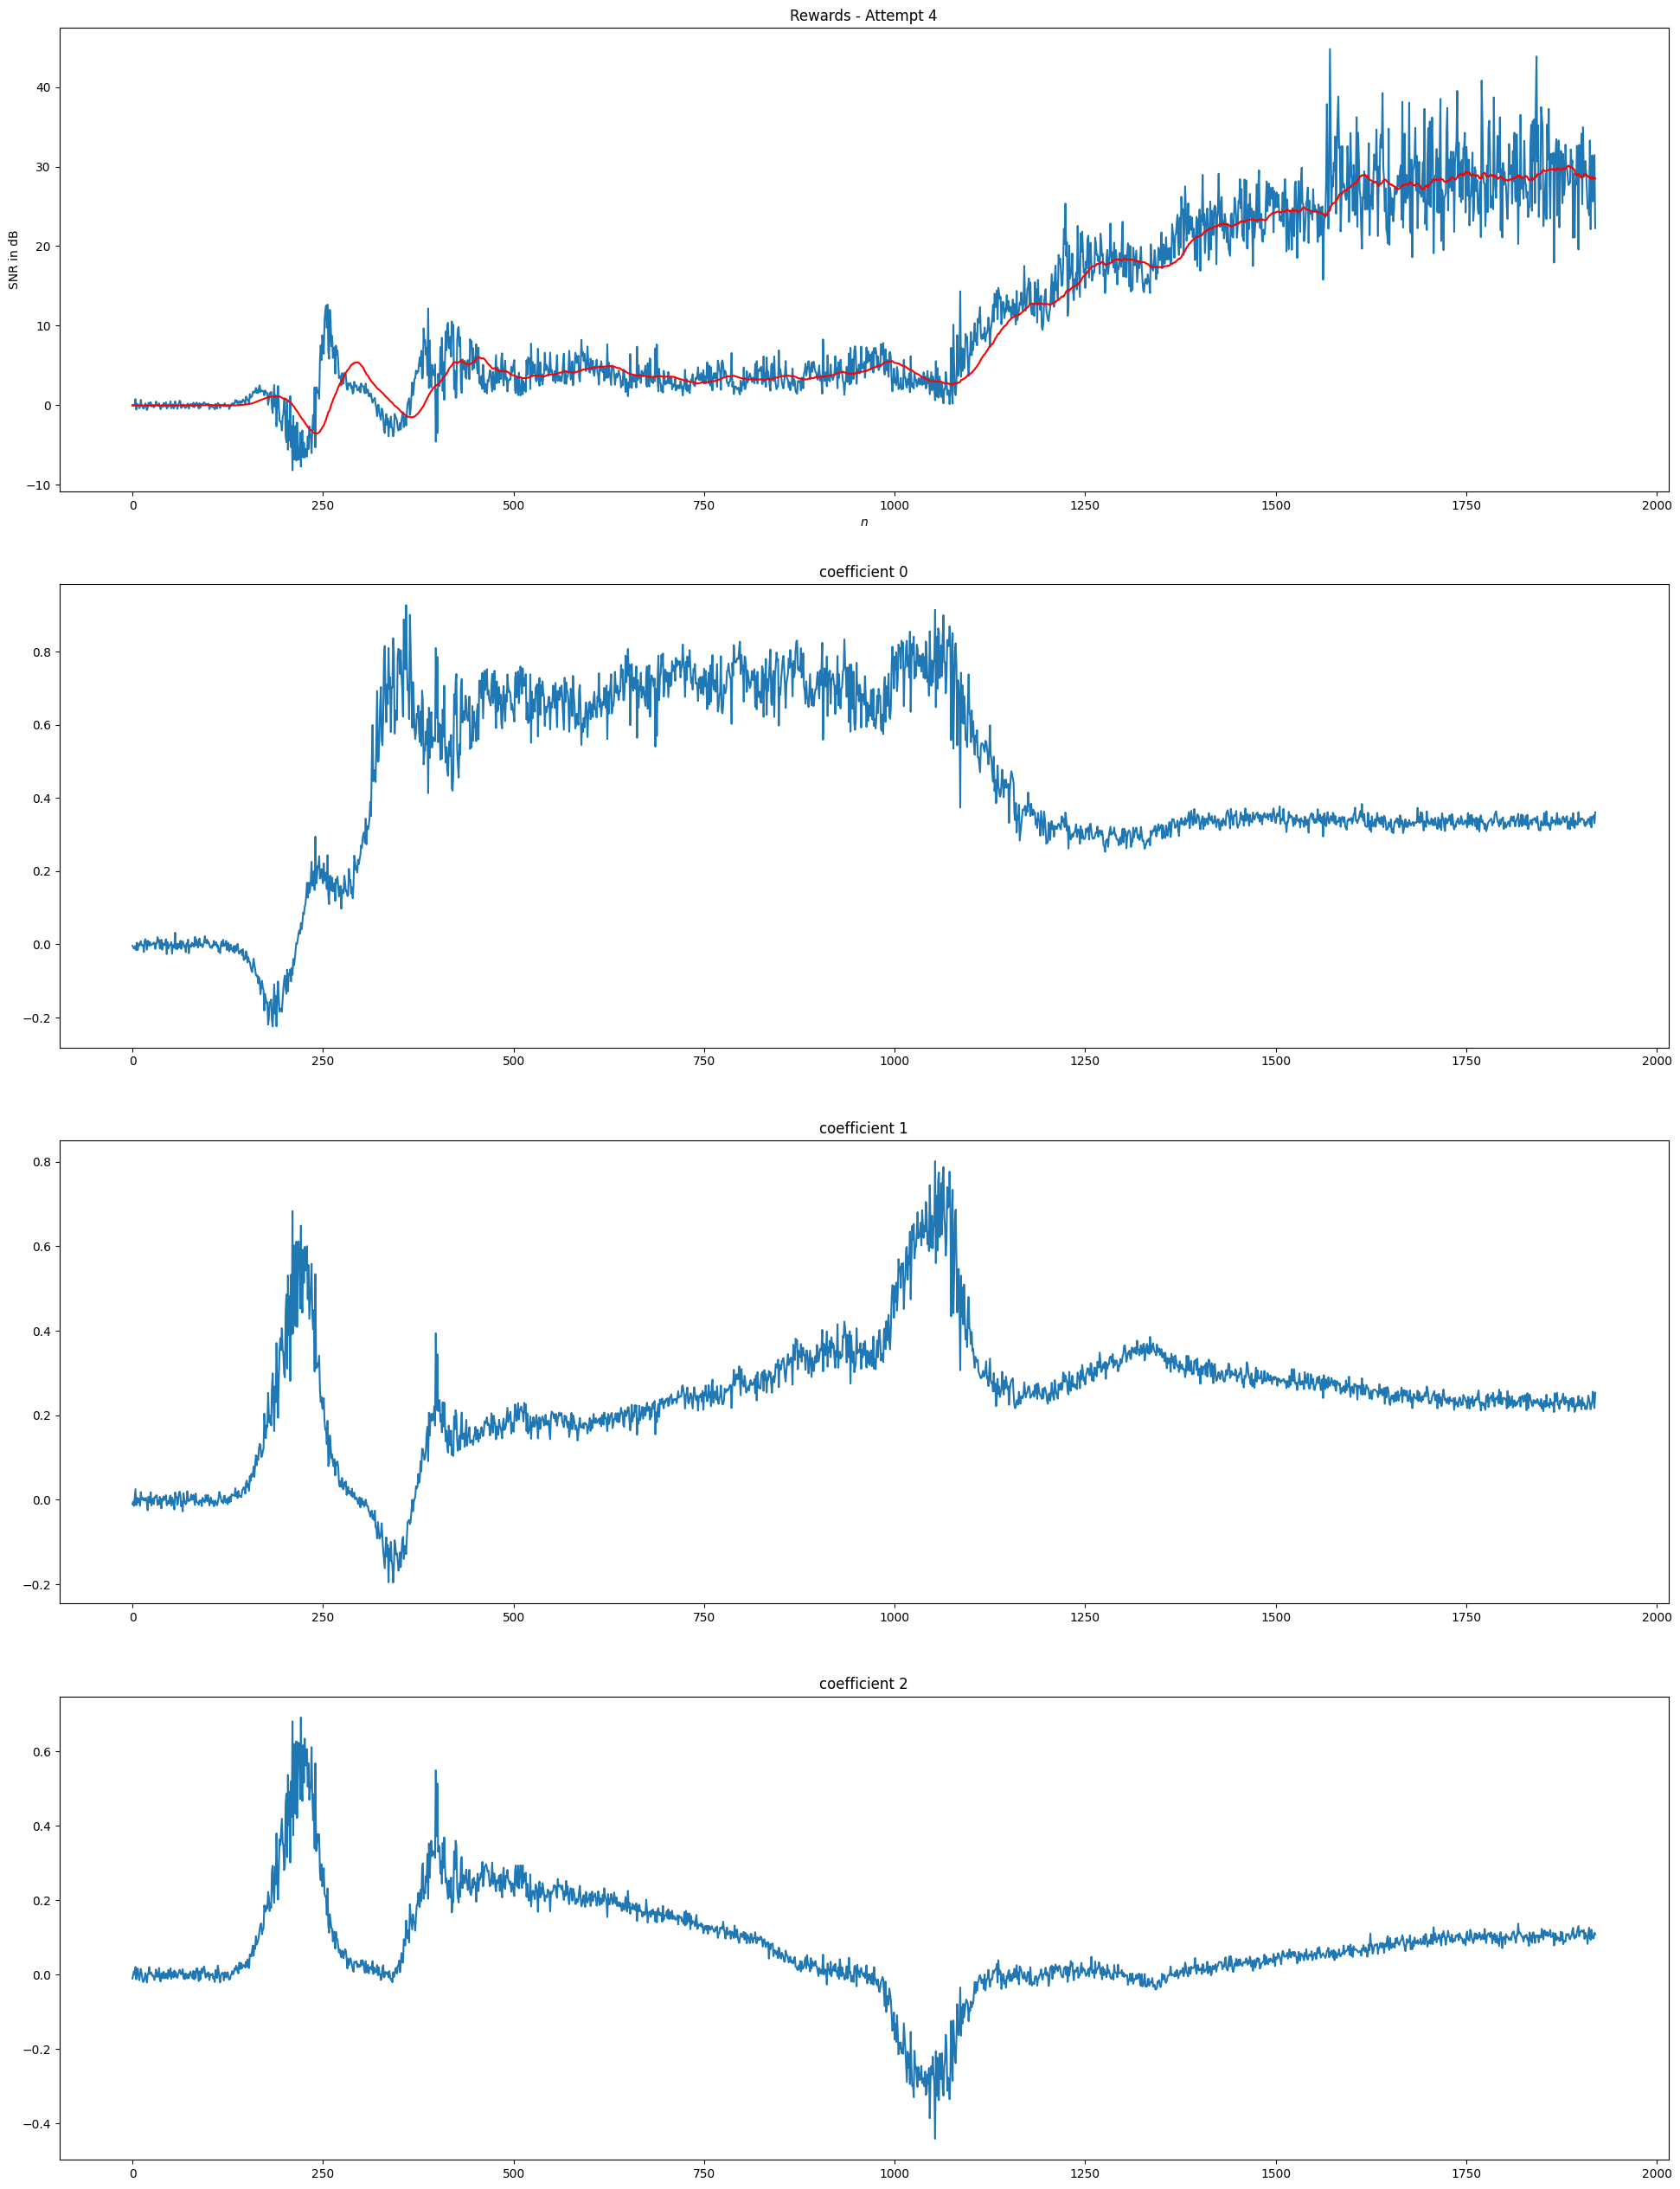

In [93]:
attempt_no = 4
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(24, 32))
ax[0].plot(np.array(reward_history))
ax[0].plot(smoother(reward_history, window_size=50), 'r')
ax[0].set_title(f"Rewards - Attempt {attempt_no}")
ax[0].set_xlabel('$n$')
ax[0].set_ylabel('SNR in dB')
ax[1].plot(np.array(action_history)[:, 0])
ax[1].set_title("coefficient 0")
ax[2].plot(np.array(action_history)[:, 1])
ax[2].set_title("coefficient 1")
ax[3].plot(np.array(action_history)[:, 2])
ax[3].set_title("coefficient 2")
# plt.plot(np.array(reward_history))

# plt.savefig(f'plots/output_plot-{attempt_no} (less LNs, tanh actions, reduced buffer).jpg')


In [94]:
# testing - initializers

final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)
final_layer_initializer(shape=(2, 2))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.5131151e-04, -1.7013946e-04],
       [-7.7674995e-05, -2.1894986e-05]], dtype=float32)>

In [106]:
# actor
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import RandomUniform

input_shape = env.observation_space.shape
fc1 = 128
fc2 = 128
n_actions = 3

hidden1_initializer = RandomUniform(minval=-1/np.sqrt(input_shape[0]), maxval=1/np.sqrt(input_shape[0]))
hidden2_initializer = RandomUniform(minval=-1/np.sqrt(fc1), maxval=1/np.sqrt(fc1))
final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)

input = Input(shape=input_shape)
hidden1 = Dense(
            units=fc1, 
            activation='relu', 
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer
            )(input)
hidden2 = Dense(
            units=fc2, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer
            )(hidden1)
output = Dense(
            units=n_actions,
            activation='tanh', # limit the action in the range [-1, 1]
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer
            )(hidden2)

actor_network = Model(inputs=input, outputs=output)
actor_network.compile(optimizer=Adam(learning_rate=0.001))
actor_network.summary()

# predict
dummy_input = np.expand_dims(env.observation_space.sample(), axis=0)
actor_network.predict(dummy_input)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 104)]             0         
                                                                 
 dense_26 (Dense)            (None, 128)               13440     
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 3)                 387       
                                                                 
Total params: 30339 (118.51 KB)
Trainable params: 30339 (118.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/home/akila/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 109ms/step


array([[-0.00043901,  0.00019638,  0.00028144]], dtype=float32)

In [18]:
def customLayerNormalization(layer):
    std_dev = np.mean((layer-0)**2)
    return layer/np.sqrt(std_dev)

audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 47706 and upper -33914 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49140.51895186492 (>=-2147483648) to max: 49149.0 (<=2147483647)
[  3   0   0  -5   0   0   2   0   1   0   0  -1  -5   0   0   2  -1   1
   0   0  -3  -4   0   0   2  -1   2   0   0  -4  -3   0   0   1  -1   2
   0   0  -5  -1   0   0   0   0   0   0   0  -5   0   0   2   0   0   5
   0   0   0   0   0   5  -1   0   0   0  -2  -7   1   0   0   0   0   0
   1  -5  -3   0   0   3

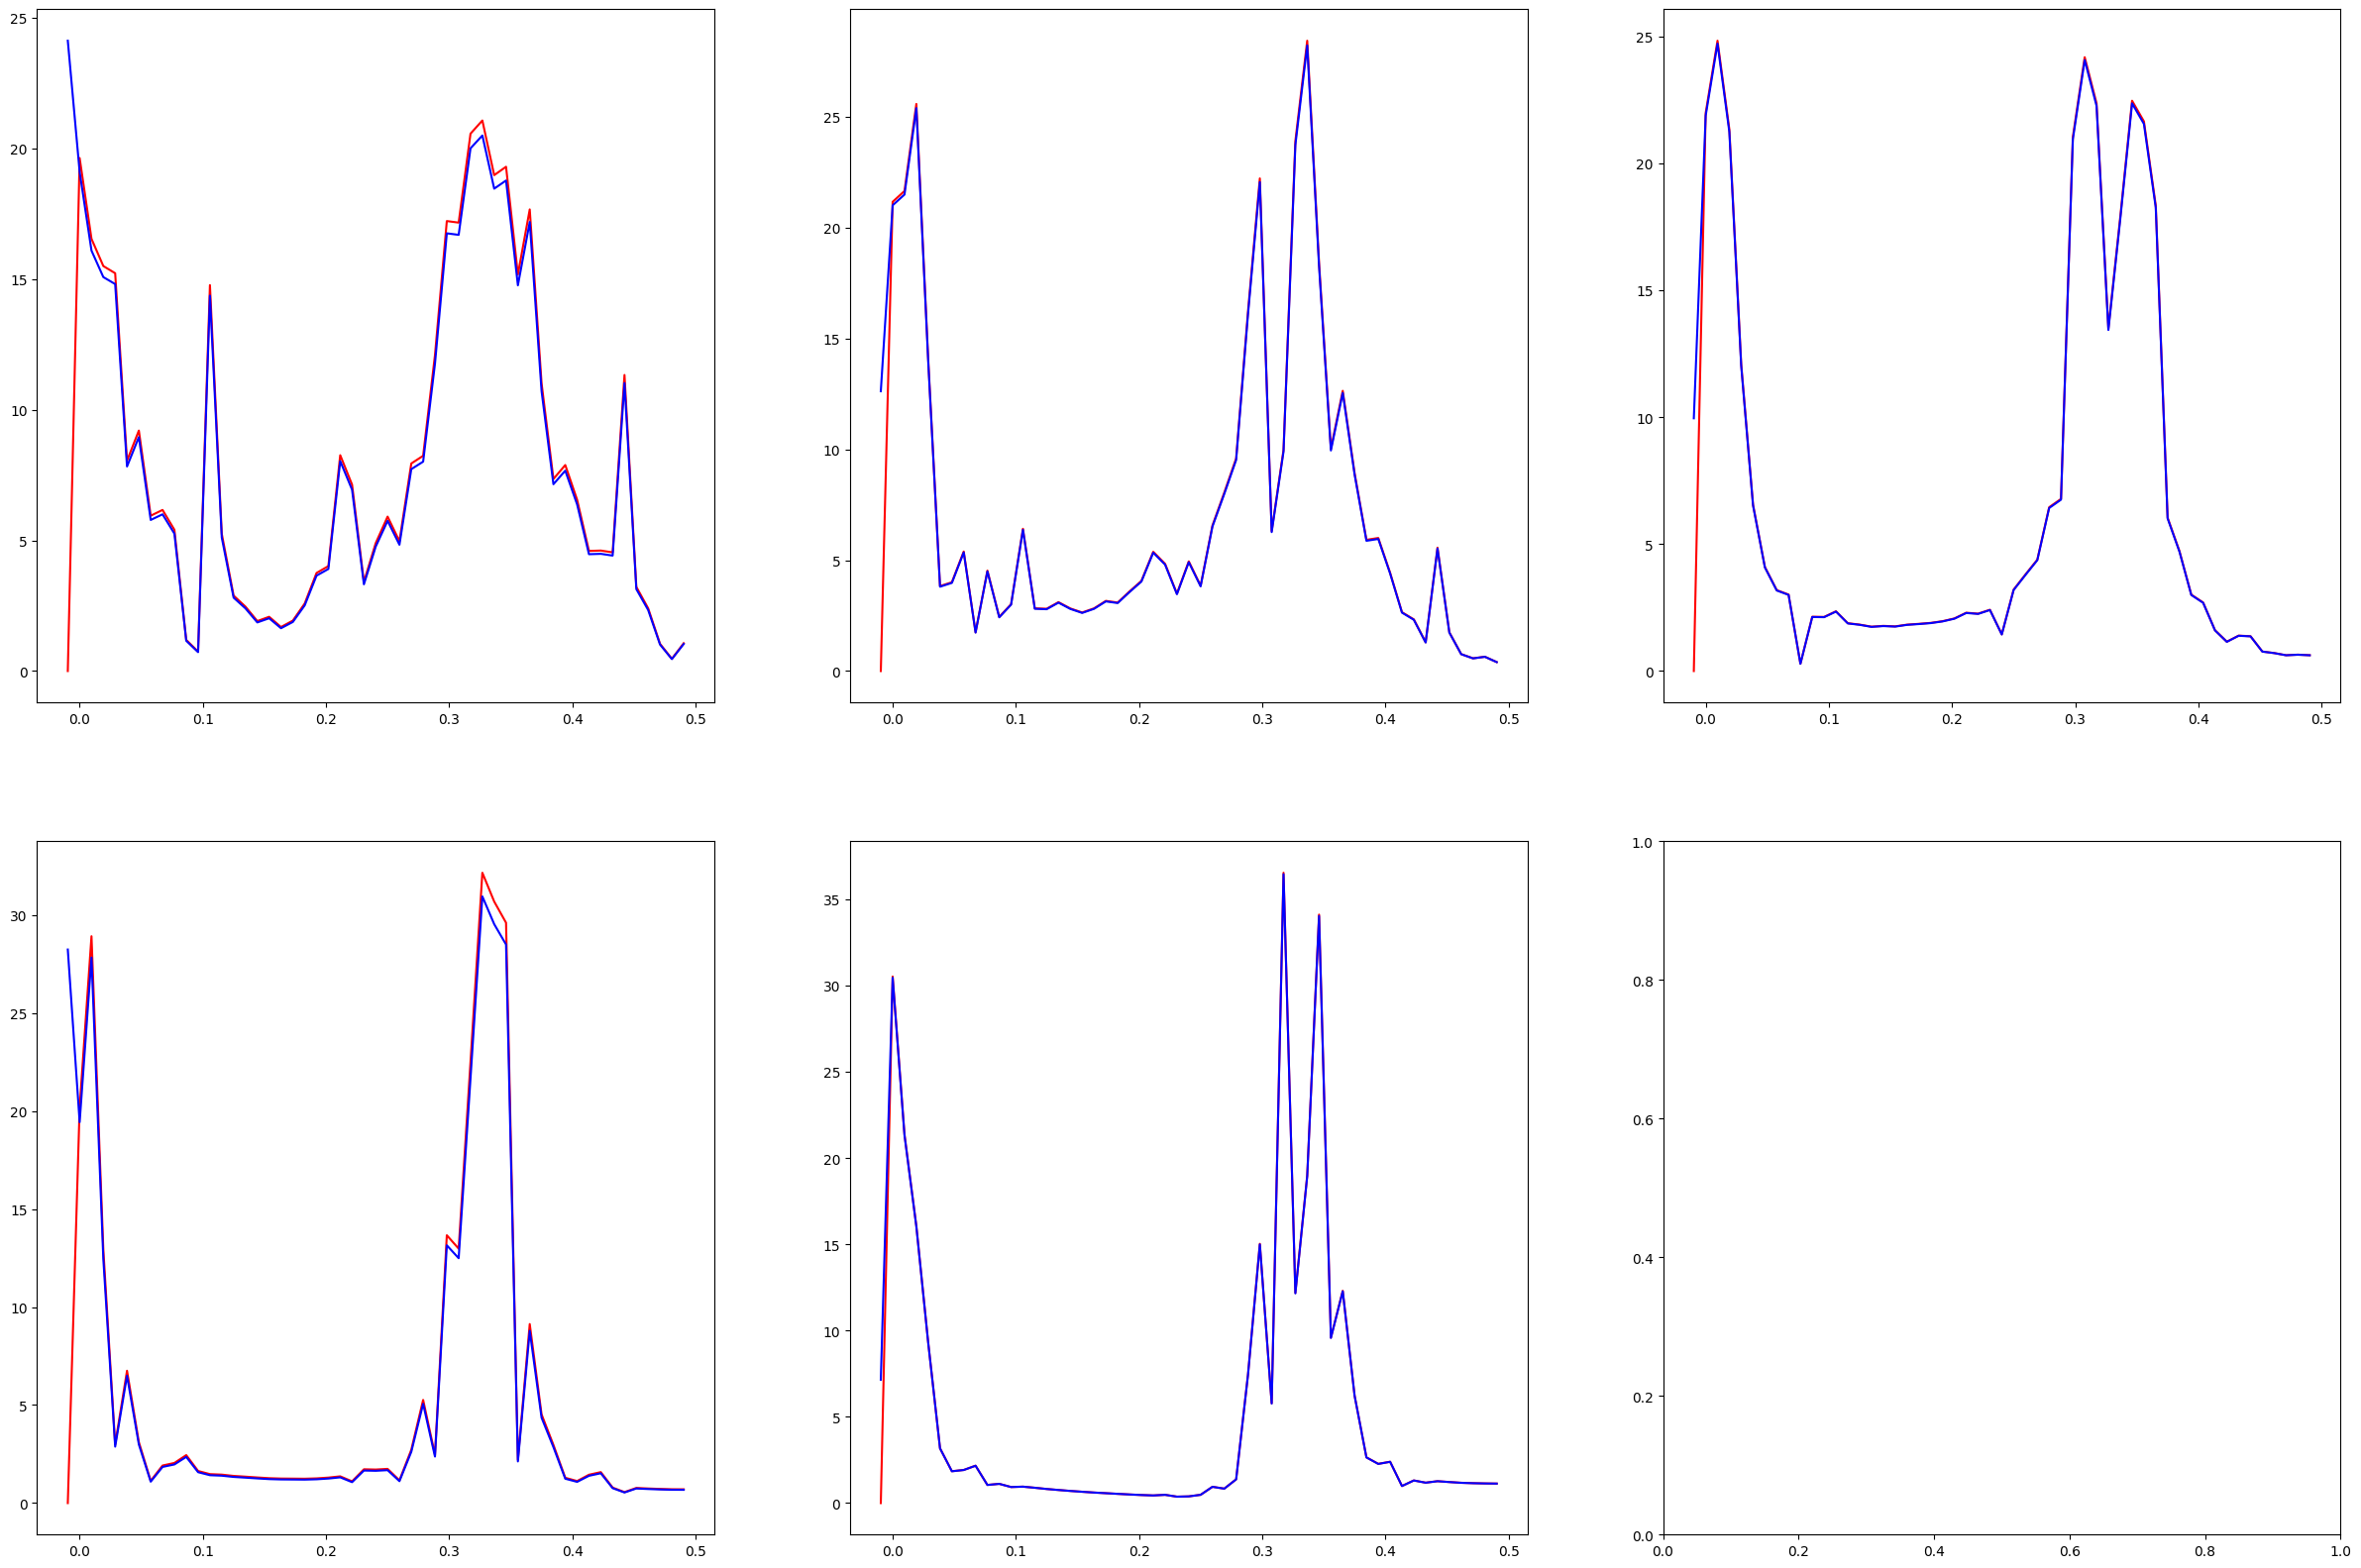

In [22]:
# testing - LayerNormalization

from tensorflow.keras.layers import LayerNormalization

audio_name = 'arms_around_you-MONO'
target_signal, jammed_signal = create_target_and_jammed_signals(audio_name, 5_000, 15_000, 100)

normalization_layer = LayerNormalization(
    axis=0,
    epsilon=0,
    center=True,
    scale=True
)

S = 100; N = 5
batch_size = S + N - 1
counter = 0
# jammed_signal = np.arange(100)+1
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
for i in range(5):
    counter += 1
    partition = jammed_signal[(counter-1)*S : (counter-1)*S + batch_size]
    print(partition)
    normalized_partition = normalization_layer(partition)
    print(normalized_partition)
    custom_normalized_partition = customLayerNormalization(partition)
    print(custom_normalized_partition)
    print('\n')
    
    # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    # ax[i//3, i%3].plot(*Spectrum(partition))
    ax[i//3, i%3].plot(*Spectrum(np.array(normalized_partition)), 'r')
    ax[i//3, i%3].plot(*Spectrum(custom_normalized_partition), 'b')